## Dataset and Problem Introduction

In this analysis, we explore AB testing for the mobile puzzle game <a href="https://www.facebook.com/cookiecatsgame">Cookie Cats</a> developed by <a href="http://tactile.dk">Tactile Entertainment</a>.

<p>The notebook analyses the impact on player retention by conducting an AB-test where we move the first gate from level 30 to level 40. Gates are what the player encounters as they progress through the game. Gates force the player to wait a certain amount of time or make an in-app purchase to avoid the wait.

Data Source: https://www.kaggle.com/arpitdw/cokie-cats
<br>Reference: https://www.datacamp.com/

In [13]:
# Importing pandas
import pandas as pd

# Reading in the data
df = pd.read_csv('datasets/cookie_cats.csv')

# Showing the first few rows
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


## AB-test data
<p>The data we have is from 90,189 players that installed the game while the AB-test was running. The variables are:</p>
<ul>
<li><code>userid</code> - a unique number that identifies each player.</li>
<li><code>version</code> - whether the player was put in the control group (<code>gate_30</code> - gate at level 30) or the group with the moved gate (<code>gate_40</code> - gate at level 40).</li>
<li><code>sum_gamerounds</code> - the number of game rounds played by the player during the first 14 days after install.</li>
<li><code>retention_1</code> - did the player come back and play <strong>1 day</strong> after installing?</li>
<li><code>retention_7</code> - did the player come back and play <strong>7 days</strong> after installing?</li>
</ul>
<p>When a player installed the game, they were randomly assigned to either <code>gate_30</code> or <code>gate_40</code>.</p>

In [14]:
# Counting the number of players in each AB group.
df.groupby('version')['userid'].count()

version
gate_30    44700
gate_40    45489
Name: userid, dtype: int64

## Distribution of game rounds
<p>Plot of the distribution of rounds players played during their first week playing the game.</p>

Text(0, 0.5, 'User Count')

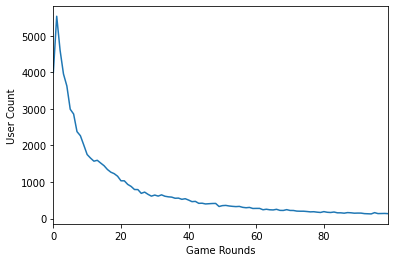

In [15]:
# This command makes plots appear in the notebook
%matplotlib inline

# Counting the number of players for each number of game rounds 
plot_df = df.groupby('sum_gamerounds')['userid'].count()

# Plotting the distribution of players that played 0 to 100 game rounds
ax = plot_df.head(n=100).plot(x="sum_gamerounds", y="userid")
ax.set_xlabel("Game Rounds")
ax.set_ylabel("User Count")

## Overall 1-day retention
<p>In the plot above we can see that some players install the game but then never play it (0 game rounds), some players just play a couple of game rounds in their first week, and some get really hooked.</p>
<p>A common metric used in the video gaming industry for measuring game engagement is <em>1-day retention</em>: The percentage of players that come back and play the game <em>one day</em> after they have installed it.  The higher the 1-day retention is, the easier it is to retain players and build a large player base. </p>

<p>The overall 1-day retention is calculated below:</p>

In [16]:
# The % of users that came back the day after they installed
df['retention_1'].sum() / df['retention_1'].count()

0.4452095044850259

A little less than half of the players come back one day after installing the game. 

## 1-day retention by AB-group
<p>Now that we have a benchmark, let's look at how 1-day retention differs between the two AB-groups.</p>

In [17]:
# Calculating 1-day retention for each AB-group
df.groupby('version')['retention_1'].sum() / df.groupby('version')['userid'].count()

version
gate_30    0.448188
gate_40    0.442283
dtype: float64

<p>It appears that there was a slight decrease in 1-day retention when the gate was moved to level 40 (44.2%) compared to the control when it was at level 30 (44.8%). It's a small change, but even small changes in retention can have a large impact.

## Bootstrapping the difference
<p>There are a couple of ways we can check the certainty of these retention numbers. Here we use bootstrapping by repeatedly re-sampling our dataset (with replacement) and calculating the 1-day retention for those samples. The variation in 1-day retention will give us an indication of how uncertain the retention numbers are.</p>

<AxesSubplot:ylabel='Density'>

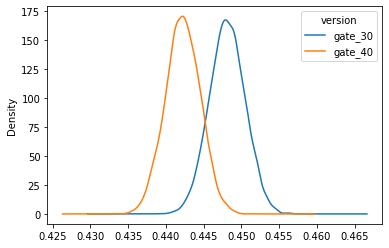

In [18]:
# Creating an list with bootstrapped means for each AB-group
boot_1d = []
for i in range(10000):
    boot_mean = df.sample(frac=1, replace=True).groupby('version')['retention_1'].mean()
    boot_1d.append(boot_mean)
    
# Transforming the list to a DataFrame
boot_1d = pd.DataFrame(boot_1d)
    
# A Kernel Density Estimate plot of the bootstrap distributions
boot_1d.plot(kind='kde')

<p>These two distributions above represent the bootstrap uncertainty over what the underlying 1-day retention could be for the two AB-groups. We can see that there seems to be some evidence of a difference, albeit small. Let's zoom in on the difference in 1-day retention</p>

Text(0.5, 0, '% difference in means')

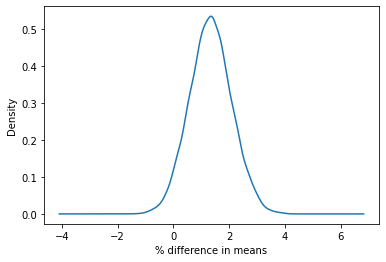

In [19]:
# Adding a column with the % difference between the two AB-groups
boot_1d['diff'] = (boot_1d['gate_30'] - boot_1d['gate_40']) /  boot_1d['gate_40'] * 100

# Ploting the bootstrap % difference
ax = boot_1d['diff'].plot(kind = 'kde')
ax.set_xlabel("% difference in means")

<p>From this chart, we can see that the most likely % difference is around 1% - 2%, and that most of the distribution is above 0%, in favour of a gate at level 30. But what is the <em>probability</em> that the difference is above 0%? 

In [21]:
# Calculating the probability that 1-day retention 
# is greater when the gate is at level 30.
prob = (boot_1d['diff'] > 0).sum() / len(boot_1d)

# Pretty printing the probability
'{:.1%}'.format(prob)

'96.4%'

## 7-day retention by AB-group
<p>The bootstrap analysis tells us that there is a high probability that 1-day retention is better when the gate is at level 30. However, since players have only been playing the game for one day, it is likely that most players haven't reached level 30 yet. That is, many players won't have been affected by the gate, even if it's as early as level 30. </p>
<p>But after having played for a week, more players should have reached level 40, and therefore it makes sense to also look at 7-day retention. That is: What percentage of the people that installed the game also showed up a week later to play the game again.</p>

In [22]:
# Calculating 7-day retention for both AB-groups
df.groupby('version')['retention_7'].sum() / df.groupby('version')['userid'].count()

version
gate_30    0.190201
gate_40    0.182000
dtype: float64

## Bootstrapping the difference again
<p>Like with 1-day retention, we see that 7-day retention is slightly lower (18.2%) when the gate is at level 40 than when the gate is at level 30 (19.0%). This difference is also larger than for 1-day retention, presumably because more players have had time to hit the first gate. We also see that the <em>overall</em> 7-day retention is lower than the <em>overall</em> 1-day retention; fewer people play a game a week after installing than a day after installing.</p>
<p>But as before, let's use bootstrap analysis to figure out how certain we should be of the difference between the AB-groups.</p>

'100.0%'

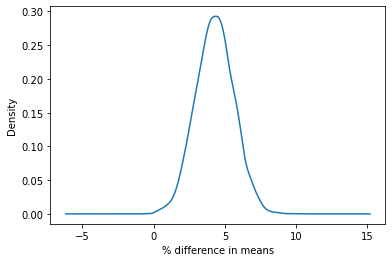

In [23]:
# Creating a list with bootstrapped means for each AB-group
boot_7d = []
for i in range(10000):
    boot_mean = df.sample(frac=1, replace=True).groupby('version')['retention_7'].mean()
    boot_7d.append(boot_mean)
    
# Transforming the list to a DataFrame
boot_7d = pd.DataFrame(boot_7d)

# Adding a column with the % difference between the two AB-groups
boot_7d['diff'] = (boot_7d['gate_30'] - boot_7d['gate_40']) /  boot_7d['gate_30'] * 100

# Ploting the bootstrap % difference
ax = boot_7d['diff'].plot(kind = 'kde')
ax.set_xlabel("% difference in means")

# Calculating the probability that 7-day retention is greater when the gate is at level 30
prob = (boot_7d['diff'] > 0).sum() / len(boot_7d)

# Pretty printing the probability
'{:.1%}'.format(prob)

## Summary
<p>The bootstrap result tells us that there is strong evidence that 7-day retention is higher when the gate is at level 30 than when it is at level 40. The conclusion is: If we want to keep retention high — both 1-day and 7-day retention — we should <strong>not</strong> move the gate from level 30 to level 40. There are, of course, other metrics we could look at, like the number of game rounds played or how much in-game purchases are made by the two AB-groups. But retention <em>is</em> one of the most important metrics. If we don't retain our player base, it doesn't matter how much money they spend in-game.</p>
<p>So, why is retention higher when the gate is positioned earlier? One could expect the opposite: The later the obstacle, the longer people are going to engage with the game. But this is not what the data tells us. The theory of <em>hedonic adaptation</em> can give one explanation for this. In short, hedonic adaptation is the tendency for people to get less and less enjoyment out of a fun activity over time if that activity is undertaken continuously. By forcing players to take a break when they reach a gate, their enjoyment of the game is prolonged. But when the gate is moved to level 40, fewer players make it far enough, and they are more likely to quit the game because they simply got bored of it. </p>